### Train a ALM in Google Colab!

In [9]:
# from google.colab import drive
# drive.mount('/content/drive')
# !cp -r /content/drive/MyDrive/nanoALM/5/stage1 /content

### Clone the repository if you don't have it already

In [3]:
import os

if not os.path.isdir('nanoALM'):
    !git clone https://github.com/LWL220184016/nanoVLM_From_Huggingface.git
%cd nanoVLM_From_Huggingface/
!ls

fatal: destination path 'nanoVLM_From_Huggingface' already exists and is not an empty directory.
/content/nanoVLM_From_Huggingface
assets			debug_func.py				  nanoALM.ipynb
benchmark-inference.py	debug_tokenizer_dataset_compatibility.py  old
benchmark_suite.py	generate.py				  __pycache__
checkpoints		measure_vram.py				  README.md
data			models					  test


### Imports and Setup

In [11]:
# Let's authentificate with the Hugging Face Hub so you can push your model
# from huggingface_hub import notebook_login
# notebook_login()
# !huggingface-cli login


In [12]:
# # If you get an "Error" from pip's dependency resolver but the cell complets fine, this is not an issue, you can continue :)
# !pip -q install torch
# !pip -q install gcsfs
# !pip -q install tqdm
# !pip -q install huggingface_hub
# !pip -q install librosa
# !pip install soundfile librosa -q
# # !pip install --upgrade transformers
# !pip install datasets==3.6.0


In [13]:
# Decide on the name of your model here!
# You will need your HF user name and the name you want to give to it
# For me, this would be "lusxvr/nanoALM"
# hf_model_name = "YOUR_HF_USER_NAME/nanoALM"

In [14]:
# nanoALM Imports (please check out the implementations in detail, that's where all the interessting stuff is!)
from data.collators import AlignmentCollator, AudioQACollator
from data.datasets import SAVEEDataset, AudioQADataset
from data.processors import get_audio_processor
from data.processors import get_tokenizer
from models.audio_language_model import AudioLanguageModel
import models.utils as utils

# Libraries
import math
import time
import torch

from tqdm import tqdm
import torch.optim as optim
import matplotlib.pyplot as plt
from dataclasses import dataclass
from torch.utils.data import DataLoader
from datasets import load_dataset, concatenate_datasets
#Otherwise, the tokenizer will through a warning
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

torch.autograd.set_detect_anomaly(True)

if torch.cuda.is_available():
    device = "cuda"
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = "mps"
else:
    try:
        import torch_xla
        import torch_xla.core.xla_model as xm

        device = xm.xla_device()
    except ImportError:
        device = "cpu"
print(f"Using device: {device}")

torch.manual_seed(0)
torch.cuda.manual_seed_all(0)
trained_model = None

# To reload the modules if you change something in the code
%reload_ext autoreload
%autoreload 2

Using device: cuda


### Get the dataloaders

In [15]:
def get_dataloaders(train_cfg, alm_cfg, tokenizer):
    # Create datasets
    audio_processor = get_audio_processor(alm_cfg)

    # text = "splitting datasets, disable in get_dataloaders function"
    # print(f"\n\033[38;5;05m{text}05m\033[0m")
    # Load and combine all training datasets
    combined_train_data = []
    for dataset_name in train_cfg.train_dataset_name:
        train_ds = load_dataset(
        path = train_cfg.train_dataset_path,
        name = dataset_name,
    )
        combined_train_data.append(train_ds['train'])
    train_ds = concatenate_datasets(combined_train_data)

    test_ds = load_dataset(train_cfg.test_dataset_path)
    train_ds = train_ds.shuffle(seed=0) # Shuffle the training dataset, so train and val get equal contributions from all concatinated datasets

    # Apply cutoff if specified
    if train_cfg.data_cutoff_idx is None:
        total_samples = len(train_ds)  # Use the entire dataset
    else:
        total_samples = min(len(train_ds), train_cfg.data_cutoff_idx)

    val_size = int(total_samples * train_cfg.val_ratio)
    train_size = total_samples - val_size

    train_dataset = AudioQADataset(train_ds.select(range(train_size)), tokenizer, audio_processor)
    val_dataset = AudioQADataset(train_ds.select(range(train_size, total_samples)), tokenizer, audio_processor)
    test_dataset = SAVEEDataset(test_ds, tokenizer, audio_processor)

    # Create collators
    alignment_collator = AlignmentCollator(tokenizer, alm_cfg.lm_max_length, audio_processor)
    aqa_collator = AudioQACollator(tokenizer, alm_cfg.lm_max_length)
    savee_collator = AudioQACollator(tokenizer, alm_cfg.lm_max_length)

    # Create dataloaders
    alignment_train_loader = DataLoader(
        train_dataset,
        batch_size=train_cfg.batch_size,
        shuffle=True,
        collate_fn=alignment_collator,
        num_workers=2,
        pin_memory=True,
        drop_last=True,
    )

    train_loader = DataLoader(
        train_dataset,
        batch_size=train_cfg.batch_size,
        shuffle=True,
        collate_fn=aqa_collator,
        num_workers=2,
        pin_memory=True,
        drop_last=True,
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=train_cfg.batch_size,
        shuffle=False,
        collate_fn=aqa_collator,
        num_workers=2,
        pin_memory=True,
        drop_last=True,
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=train_cfg.savee_batch_size,
        shuffle=False,
        collate_fn=savee_collator,
        pin_memory=True,
        )

    return alignment_train_loader, train_loader, val_loader, test_loader

### Prepare the testing function

In [16]:
def test_savee(model, tokenizer, test_loader, device):
    total_examples = 0
    correct_predictions = 0
    with torch.no_grad():
        for batch in test_loader:
            audio = batch['audios'].to(device)
            input_ids = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            correct_answer = tokenizer.batch_decode(labels, skip_special_tokens=True)

            gen = model.generate(input_ids, audio, attention_mask)
            model_output = tokenizer.batch_decode(gen, skip_special_tokens=True)

            is_correct = utils.check_multiple_choice_with_regex(model_output, correct_answer)

            total_examples += len(is_correct)
            if is_correct:
                correct_predictions += sum(is_correct)
    accuracy = correct_predictions / total_examples if total_examples > 0 else 0
    return accuracy

def get_avg_alignment(model, val_loader, device, epoch):
    """
    Validate the model's audio-text alignment on the validation set.
    This function computes the average alignment score over the validation set.
    It runs for a maximum of 20 batches to save time during training.
    """
    model.eval()
    total_alignment_score = 0

    with torch.no_grad():
        for i, batch in enumerate(val_loader):
            if i >= 20:  # 只驗證前20個batch以節省時間
                break
            audios = batch["audio"].to(device)
            input_ids = batch["input_ids"].to(device)
            alignment_score = model.validate_audio_text_alignment(input_ids, audios)
            total_alignment_score += alignment_score

    avg_alignment = total_alignment_score / min(20, len(val_loader))
    print(f"Epoch {epoch+1}: Average alignment score: {avg_alignment:.4f}")

    print(" ")
    model.train()
    return avg_alignment

### Add debug

In [17]:
# 在训练开始前添加这个检查函数
def debug_model_dimensions(model, input_ids, audio):
    """调试模型各层的维度"""
    print("=== Model Dimension Debug ===")

    # 检查音频编码器
    audio_features = model.audio_encoder.forward(audio, output_hidden_states=True)
    print(f"Audio features shape: {audio_features.shape}")

    # 检查模态投影器
    audio_embeds = model.MP(audio_features)
    print(f"Audio embeds shape: {audio_embeds.shape}")

    # 检查文本嵌入
    text_embeds = model.decoder.token_embedding(input_ids)
    print(f"Text embeds shape: {text_embeds.shape}")

    # 检查拼接后的嵌入
    inputs_embeds = torch.cat([audio_embeds, text_embeds], dim=1)
    print(f"Combined embeds shape: {inputs_embeds.shape}")

    # 检查语言模型输出
    logits = model.decoder(inputs_embeds)
    print(f"Logits shape: {logits.shape}")
    print(f"Vocab size (last dim): {logits.shape[-1]}")

    # 检查语言模型配置
    print(f"LM vocab size config: {model.cfg.lm_vocab_size}")
    print(f"Decoder vocab size: {getattr(model.decoder, 'vocab_size', 'Not found')}")

    return logits.shape[-1]

# 在训练循环开始前调用
# vocab_size = debug_model_dimensions(model, input_ids, audios)

In [18]:
def debug_training_step(model, input_ids, audios, attention_mask, labels):
    """调试训练步骤"""
    # 添加这些调试行：
    print(f"Batch debug - input_ids shape: {input_ids.shape}, max: {input_ids.max().item()}")
    print(f"Batch debug - labels shape: {labels.shape}, max: {labels.max().item()}")
    print(f"Batch debug - Model vocab config: {model.cfg.lm_vocab_size}")

    # 检查decoder的实际vocab_size
    if hasattr(model.decoder, 'head') and hasattr(model.decoder.head, 'out_features'):
        print(f"Decoder head in_features: {model.decoder.head.in_features}")
        print(f"Decoder head out_features: {model.decoder.head.out_features}")

### Prepare the training loop

#### Three-stage training (contrast training, generative training, instruction fine-tuning) 三段式訓練(對比訓練, 生成式訓練, 指令微調)

In [19]:
import torch.nn.functional as F
import torch.nn as nn
import torch.amp as GradScaler

from debug_func import debug_contrastive_learning

# 改進對比學習訓練
def get_lr(it, max_lr, max_steps):
    min_lr = max_lr * 0.1
    warmup_steps = max_steps * 0.03
    # 1) linear warmup for warmup_iters steps
    if it < warmup_steps:
        return max_lr * (it+1) / warmup_steps
    # 2) if it > lr_decay_iters, return min learning rate
    if it > max_steps:
        return min_lr
    # 3) in between, use cosine decay down to min learning rate
    decay_ratio = (it - warmup_steps) / (max_steps - warmup_steps)
    assert 0 <= decay_ratio <= 1
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio)) # coeff starts at 1 and goes to 0
    return min_lr + coeff * (max_lr - min_lr)

def get_contrastive_loss(audio_embeds, text_embeds, temperature=0.07):
    """
    標準、高效的對比學習損失 (CLIP Loss)。
    注意：輸入的 embeds 應該是池化後的 [B, D] 維度向量。
    """
    # --- 開始計算尺度對齊損失 ---

    # 1. 計算每個向量的 L2 範數 (沿著最後一個維度)
    #    detach() 是為了確保這個輔助損失的梯度只流向投影器，而不影響上游的編碼器或文字嵌入層的穩定性（可選但推薦）
    audio_norms = torch.norm(audio_embeds, p=2, dim=-1)
    text_norms = torch.norm(text_embeds, p=2, dim=-1)

    # 2. 計算批次內的平均範數
    mean_audio_norm = torch.mean(audio_norms)
    mean_text_norm = torch.mean(text_norms)

    # 3. 計算尺度對齊損失 (使用 MSE)
    #    目標是讓 mean_audio_norm 和 mean_text_norm 盡可能接近
    scale_loss = F.mse_loss(mean_audio_norm, mean_text_norm)

    # --- 結束計算尺度對齊損失 ---

    # --- 開始計算交叉熵損失 ---
    # 歸一化
    audio_embeds = F.normalize(audio_embeds, p=2, dim=-1)
    text_embeds = F.normalize(text_embeds, p=2, dim=-1)

    # 計算相似度矩陣
    # temperature 是一個重要的超參數，CLIP 論文中是可學習的，但固定值也可以
    logits_per_audio = torch.matmul(audio_embeds, text_embeds.T) / temperature
    logits_per_text = logits_per_audio.T

    # 創建標籤 (0, 1, 2, ..., B-1)
    labels = torch.arange(audio_embeds.shape[0]).to(logits_per_audio.device)

    # 對稱的交叉熵損失
    loss_a = F.cross_entropy(logits_per_audio, labels)
    loss_t = F.cross_entropy(logits_per_text, labels)

    contrastive_loss = (loss_a + loss_t) / 2

    # --- 結束計算交叉熵損失 ---


    # 4. 組合損失
    #    lambda_scale 是一個需要調整的超參數，用來平衡兩個損失的權重
    lambda_scale = 0.001  # 範例值，可以從 0.01, 0.1, 1.0 等開始嘗試
    total_loss = contrastive_loss + lambda_scale * scale_loss

    # 監控指標 (可選但推薦)
    with torch.no_grad():
        pos_sim = torch.diagonal(logits_per_audio * temperature).mean()
        mask = ~torch.eye(labels.shape[0], dtype=torch.bool, device=labels.device)
        neg_sim = (logits_per_audio * temperature)[mask].mean()

    return total_loss, contrastive_loss, scale_loss, {
        "loss": total_loss.item(),
        "pos_sim": pos_sim.item(), # 正樣本對的餘弦相似度
        "neg_sim": neg_sim.item()  # 負樣本對的餘弦相似度
    }

def train_step1_alignment(train_cfg, alm_cfg, model=None, tokenizer = None, device = None):
    # 凍結音頻編碼器和語言模型
    model.audio_encoder.audio_encoder.requires_grad_(False)
    model.decoder.requires_grad_(False)
    model.MP.requires_grad_(True)

    alignment_train_loader, _, val_loader, _ = get_dataloaders(train_cfg, alm_cfg, tokenizer)

    optimizer = optim.AdamW(model.MP.parameters(), lr=train_cfg.lr_mp, weight_decay=0.01)

    best_alignment = 0

    for epoch in range(train_cfg.stage1_epochs):
        model.train()
        total_contrastive_loss = 0  # 添加這個變數初始化
        total_scale_loss = 0  # 添加這個變數初始化

        for batch in tqdm(alignment_train_loader, desc=f"Stage1 Epoch {epoch+1}"):
            audios = batch["audio"].to(device)
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)

            optimizer.zero_grad()

            # 1. 音頻編碼 -> 投影
            with torch.no_grad():
                audio_features = model.audio_encoder.audio_encoder(audios, output_hidden_states=True)
            projected_audio_features = model.MP(audio_features.last_hidden_state)

            # 2. 文本編碼 - 修復這裡的問題
            with torch.no_grad():
                # 檢查 decoder 的 forward 方法簽名
                # 根據 language_model.py，應該傳入 x 而不是分別的參數
                text_embeds = model.decoder.token_embedding(input_ids)  # 直接獲取文本嵌入

                # 如果需要通過完整的 decoder，使用以下方式：
                # text_outputs, _ = model.decoder(text_embeds, attention_mask=attention_mask)
                # text_embeds = text_outputs  # 使用輸出的嵌入

            # 3. 池化操作 (Pooling)
            # 音頻池化
            audio_pooled = projected_audio_features.mean(dim=1)  # [B, D]

            # 文本池化 - 修復維度問題
            # text_embeds 現在是 [B, seq_len, hidden_dim]
            if attention_mask is not None:
                # 根據 attention_mask 來安全地做平均池化
                input_mask_expanded = attention_mask.unsqueeze(-1).expand(text_embeds.size()).float()
                sum_embeddings = torch.sum(text_embeds * input_mask_expanded, 1)
                sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
                text_pooled = sum_embeddings / sum_mask  # [B, D]
            else:
                text_pooled = text_embeds.mean(dim=1)  # [B, D]

            # 如果維度仍然不匹配，添加投影層
            if audio_pooled.shape[-1] != text_pooled.shape[-1]:
                # 創建一個投影層來匹配維度
                if not hasattr(model, 'text_projection'):
                    model.text_projection = nn.Linear(text_pooled.shape[-1], audio_pooled.shape[-1]).to(device)
                text_pooled = model.text_projection(text_pooled)

            # 4. 計算對比損失
            loss, contrastive_loss, scale_loss, metrics = get_contrastive_loss(audio_pooled, text_pooled)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.MP.parameters(), max_norm=1.0)
            optimizer.step()

            total_contrastive_loss += contrastive_loss.item()
            total_scale_loss += scale_loss.item()

        avg_contrastive_loss = total_contrastive_loss / len(alignment_train_loader)
        avg_scale_loss = total_scale_loss / len(alignment_train_loader)
        print(f"Stage1 Epoch {epoch+1}: Total Loss {loss:.4f}, Contrastive Loss {avg_contrastive_loss:.4f}, Scale Loss {avg_scale_loss:.4f}")

        avg_alignment = get_avg_alignment(model, val_loader, device, epoch)

        if avg_alignment > best_alignment:
            best_alignment = avg_alignment
            model.save_pretrained(save_directory=f"{alm_cfg.alm_checkpoint_path}/stage1_best")
            print(f"  New best alignment: {best_alignment:.4f}")

    print(f"Stage 1 completed! Best alignment: {best_alignment:.4f}")
    return model

def train_step2_pretraining(train_cfg, alm_cfg, stage1_model=None, tokenizer=None, device = None):
    """第二步：语言模型预训练"""
    print("=== Stage 2: Language Model Pretraining ===")

    _, train_loader, val_loader, test_loader = get_dataloaders(train_cfg, alm_cfg, tokenizer)
    tokenizer = get_tokenizer(alm_cfg.lm_tokenizer)

    # 加载第一阶段模型或从头开始
    if stage1_model is not None:
        model = stage1_model
    else:
        try:
            model = AudioLanguageModel.from_pretrained(f"{alm_cfg.alm_checkpoint_path}/stage1_final")
            print("Loaded Stage 1 model")
        except:
            model = AudioLanguageModel(alm_cfg, load_backbone=True, tokenizer=tokenizer, device=device)
            print("Starting Stage 2 from scratch")

    # 冻结音频编码器，解冻语言模型和模态投影器
    for param in model.audio_encoder.audio_encoder.parameters():
        param.requires_grad = False
    for param in model.decoder.parameters():
        param.requires_grad = True
    for param in model.MP.parameters():
        param.requires_grad = True

    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Stage 2: Training {trainable_params:,} parameters")

    # 不同学习率
    param_groups = [
        {'params': model.MP.parameters(), 'lr': train_cfg.lr_mp * 0.1},
        {'params': model.decoder.parameters(), 'lr': train_cfg.lr_backbones}
    ]
    optimizer = optim.AdamW(param_groups)
    scaler = torch.amp.GradScaler(device=device)


    if train_cfg.compile:
        model = torch.compile(model)

    batch_losses = []
    val_losses = []
    val_plot_steps = []
    best_loss = float('inf')
    global_step = 0

    for epoch in range(train_cfg.stage2_epochs):
        model.train()
        total_train_loss = 0

        for batch in tqdm(train_loader, desc=f"Stage2 Epoch {epoch+1}"):
            audios = batch["audio"].to(device)
            input_ids = batch["input_ids"].to(device)
            labels = batch["labels"].to(device)
            attention_mask = batch["attention_mask"].to(device)

            optimizer.zero_grad()

            with torch.autocast(device_type='cuda', dtype=torch.float16):
                # 使用因果语言建模损失
                logits, loss = model(input_ids, audios, attention_mask=attention_mask, targets=labels)

            # print("loss: ", loss)
            scaler.scale(loss).backward()
            # loss.backward()

            # 动态学习率调整
            adj_lr_mp = get_lr(global_step, train_cfg.lr_mp * 0.1, len(train_loader) * train_cfg.stage2_epochs)
            adj_lr_backbones = get_lr(global_step, train_cfg.lr_backbones, len(train_loader) * train_cfg.stage2_epochs)
            optimizer.param_groups[0]['lr'] = adj_lr_mp
            optimizer.param_groups[1]['lr'] = adj_lr_backbones

            scaler.unscale_(optimizer)
            # 2. 對 unscale 後的梯度進行裁剪 (max_norm=1.0 是一個常用的值)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            # --- 修改結束 ---

            if torch.isnan(loss).any():
                print("!!! Loss is NaN before backward pass. Problem is in the forward pass.")
                print(loss)
                # 檢查 logits 是否包含 NaN 或 inf
                if torch.isnan(logits).any():
                    print("!!! Logits contain NaN.")
                if torch.isinf(logits).any():
                    print("!!! Logits contain Inf.")
                # 在此處中斷，以便檢查
                import sys; sys.exit()
            # --- 調試碼結束 ---

            # # 3. Scaler 執行優化器步驟 (如果梯度沒有 inf/nan)
            scaler.step(optimizer)
            # # 4. 更新 scaler 的縮放因子
            scaler.update()
            # optimizer.step()

            batch_loss = loss.item()
            total_train_loss += batch_loss
            batch_losses.append(batch_loss)

            global_step += 1

        avg_train_loss = total_train_loss / len(train_loader)

        if avg_train_loss < best_loss:
            best_loss = avg_train_loss
            model.save_pretrained(save_directory=f"{alm_cfg.alm_checkpoint_path}/stage2_best")

        avg_alignment = get_avg_alignment(model, val_loader, device, epoch)
        print(f"Stage2 Epoch {epoch+1}/{train_cfg.stage2_epochs} | Loss: {avg_train_loss:.4f} | Alignment: {avg_alignment:.4f}")

    # 保存第二阶段模型
    model.save_pretrained(save_directory=f"{alm_cfg.alm_checkpoint_path}/stage2_final")
    print("Stage 2 completed!")
    plt.plot(batch_losses, label='Train Loss')
    plt.plot(val_plot_steps, val_losses, label='Val Loss')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.grid(True)
    plt.legend()
    plt.show()

    return model

def train_step3_instruction_tuning(train_cfg, alm_cfg, stage2_model=None, tokenizer=None, device = None):
    """第三步：指令微调"""
    print("=== Stage 3: Instruction Tuning ===")

    _, train_loader, val_loader, test_loader = get_dataloaders(train_cfg, alm_cfg, tokenizer)
    scaler = torch.amp.GradScaler(device=device)

    # 加载第二阶段模型
    if stage2_model is not None:
        model = stage2_model
    else:
        try:
            model = AudioLanguageModel.from_pretrained(f"{alm_cfg.alm_checkpoint_path}/stage2_final")
            print("Loaded Stage 2 model")
        except:
            print("No Stage 2 model found, using current model")
            model = AudioLanguageModel(alm_cfg, load_backbone=True, tokenizer=tokenizer, device=device)

    # 全部解冻，使用较小学习率
    for param in model.parameters():
        param.requires_grad = True

    print(f"Stage 3: Training all {sum(p.numel() for p in model.parameters()):,} parameters")

    # 更小的学习率
    param_groups = [
        {'params': model.MP.parameters(), 'lr': train_cfg.lr_mp * 0.01},
        {'params': model.decoder.parameters(), 'lr': train_cfg.lr_backbones * 0.1},
        {'params': model.audio_encoder.parameters(), 'lr': train_cfg.lr_backbones * 0.01}
    ]
    optimizer = optim.AdamW(param_groups)

    if train_cfg.compile:
        model = torch.compile(model)

    # 这里可以使用原来的训练循环，但数据应该是指令格式
    # 暂时使用相同的数据格式
    best_accuracy = 0
    global_step = 0

    for epoch in range(train_cfg.stage3_epochs):
        model.train()
        total_train_loss = 0

        for batch in tqdm(train_loader, desc=f"Stage3 Epoch {epoch+1}"):
            audios = batch["audio"].to(device)
            input_ids = batch["input_ids"].to(device)
            labels = batch["labels"].to(device)
            attention_mask = batch["attention_mask"].to(device)

            optimizer.zero_grad()

            with torch.autocast(device_type='cuda', dtype=torch.float16):
                _, loss = model(input_ids, audios, attention_mask=attention_mask, targets=labels)

            scaler.unscale_(optimizer)
            # 2. 對 unscale 後的梯度進行裁剪 (max_norm=1.0 是一個常用的值)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            # --- 修改結束 ---

            # 3. Scaler 執行優化器步驟 (如果梯度沒有 inf/nan)
            scaler.step(optimizer)
            # 4. 更新 scaler 的縮放因子
            scaler.update()

            batch_loss = loss.item()
            total_train_loss += batch_loss

            if global_step % 50 == 0:
                print(f"Stage3 Step: {global_step}, Instruction Loss: {batch_loss:.4f}")

            global_step += 1

        avg_train_loss = total_train_loss / len(train_loader)

        # 评估性能
        if train_cfg.eval_in_epochs:
            accuracy = test_savee(model, tokenizer, test_loader, device)
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                model.save_pretrained(save_directory=f"{alm_cfg.alm_checkpoint_path}/stage3_best")
            print(f"Stage3 Epoch {epoch+1}/{train_cfg.stage3_epochs} | Loss: {avg_train_loss:.4f} | Accuracy: {accuracy:.4f}")
        else:
            print(f"Stage3 Epoch {epoch+1}/{train_cfg.stage3_epochs} | Instruction Loss: {avg_train_loss:.4f}")

    # 保存最终模型
    model.save_pretrained(save_directory=f"{alm_cfg.alm_checkpoint_path}/final_model")
    print("Stage 3 completed!")
    return model

def train_three_stages(train_cfg, alm_cfg, device = None):
    """完整的三阶段训练"""
    print("Starting Three-Stage Training Pipeline")

    # 第一阶段：模态投影器对齐
    stage1_model = train_step1_alignment(train_cfg, alm_cfg, device=device)

    # 第二阶段：语言模型预训练
    stage2_model = train_step2_pretraining(train_cfg, alm_cfg, stage1_model, device=device)

    # 第三阶段：指令微调
    final_model = train_step3_instruction_tuning(train_cfg, alm_cfg, stage2_model, device=device)

    print("=== Training Pipeline Completed! ===")
    return stage1_model, stage2_model, final_model


# # 替换原来的训练调用
# alm_cfg = ALMConfig()
# train_cfg = TrainConfig()

# # 运行三阶段训练
# final_model = train_three_stages(train_cfg, alm_cfg)

### Lets run the training!

In [12]:
import os
from models.config import ALMConfig, TrainConfig

# 要創建的目錄路徑
dir_name = ALMConfig.alm_checkpoint_path

try:
    os.mkdir(dir_name)
    print(f"Directory '{dir_name}' created successfully.")
except FileExistsError:
    print(f"Directory '{dir_name}' already exists.")
except FileNotFoundError:
    print(f"Parent directory does not exist for '{dir_name}'.")
except Exception as e:
    print(f"An error occurred: {e}")

alm_cfg = ALMConfig()
train_cfg = TrainConfig()

tokenizer = get_tokenizer(alm_cfg.lm_tokenizer)

# 創建一個帶有新 token 的模型實例
model = AudioLanguageModel(alm_cfg, load_backbone=True, tokenizer=tokenizer, device=device)
stage1_model = None

if train_cfg.resume_from_alm_checkpoint:
    # checkpoint_path = "../stage1/model.safetensors"
    checkpoint_path = "./checkpoints/stage2_final/model.safetensors"

    print(f"Loading weights from {checkpoint_path} with non-strict loading.")

    # 載入舊的 state_dict
    # 注意：這裡假設您的權重是以 safetensors 格式保存的
    from safetensors.torch import load_file
    state_dict = load_file(checkpoint_path, device="cpu") # move to GPU later
    state_dict.pop('decoder.token_embedding.weight', None)
    state_dict.pop('decoder.head.weight', None)
    # *** 修改結束 ***

    # 使用 strict=False 來載入權重
    # 這會載入所有維度匹配的權重（例如 MP），並忽略不匹配的（例如 decoder.head）
    incompatible_keys = model.load_state_dict(state_dict, strict=False)

    print("Weights loaded.")
    print("Mismatched keys (should be decoder embedding/head):", incompatible_keys.missing_keys)
    print("Unexpected keys:", incompatible_keys.unexpected_keys)

# 將模型移動到正確的設備
model.to(device)
stage1_model = model

Directory 'checkpoints' already exists.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading from backbone weights
Successfully loaded HuggingFaceTB/SmolLM2-1.7B weights from safetensors. Model has 1,711,376,384 parameters.
Loading weights from ../stage1/model.safetensors with non-strict loading.
Weights loaded.
Mismatched keys (should be decoder embedding/head): ['decoder.token_embedding.weight', 'decoder.head.weight']
Unexpected keys: ['audio_encoder.decoder.embed_positions.weight', 'audio_encoder.decoder.embed_tokens.weight', 'audio_encoder.decoder.layer_norm.bias', 'audio_encoder.decoder.layer_norm.weight', 'audio_encoder.decoder.layers.0.encoder_attn.k_proj.weight', 'audio_encoder.decoder.layers.0.encoder_attn.out_proj.bias', 'audio_encoder.decoder.layers.0.encoder_attn.out_proj.weight', 'audio_encoder.decoder.layers.0.encoder_attn.q_proj.bias', 'audio_encoder.decoder.layers.0.encoder_attn.q_proj.weight', 'audio_encoder.decoder.layers.0.encoder_attn.v_proj.bias', 'audio_encoder.decoder.layers.0.encoder_attn.v_proj.weight', 'audio_encoder.decoder.layers.0.encoder_a

In [13]:
# stage1_model = train_step1_alignment(train_cfg, alm_cfg, model, tokenizer, device)
# stage1_model.save_pretrained("/content/")

=== Stage 2: Language Model Pretraining ===
AudioProcessor_from_HF initialized with model: <class 'transformers.models.whisper.processing_whisper.WhisperProcessor'>
  Target feature frames from cfg: 1500
  Using model sampling rate: 16000, hop_length: 160, n_fft: 400
  Calculated max raw audio samples for processor: 240240
Stage 2: Training 1,981,650,944 parameters


Stage2 Epoch 1: 100%|██████████| 205/205 [05:48<00:00,  1.70s/it]


Epoch 1: Average alignment score: 0.7063
 
Stage2 Epoch 1/12 | Loss: 7.6514 | Alignment: 0.7063


Stage2 Epoch 2: 100%|██████████| 205/205 [05:49<00:00,  1.71s/it]


Epoch 2: Average alignment score: 0.7188
 
Stage2 Epoch 2/12 | Loss: 4.2688 | Alignment: 0.7188


Stage2 Epoch 3: 100%|██████████| 205/205 [05:49<00:00,  1.71s/it]


Epoch 3: Average alignment score: 0.7188
 
Stage2 Epoch 3/12 | Loss: 4.0599 | Alignment: 0.7188


Stage2 Epoch 4: 100%|██████████| 205/205 [05:49<00:00,  1.71s/it]


Epoch 4: Average alignment score: 0.7250
 
Stage2 Epoch 4/12 | Loss: 3.9534 | Alignment: 0.7250


Stage2 Epoch 5: 100%|██████████| 205/205 [05:49<00:00,  1.70s/it]


Epoch 5: Average alignment score: 0.6937
 
Stage2 Epoch 5/12 | Loss: 3.8855 | Alignment: 0.6937


Stage2 Epoch 6: 100%|██████████| 205/205 [05:49<00:00,  1.71s/it]


Epoch 6: Average alignment score: 0.7063
 
Stage2 Epoch 6/12 | Loss: 3.8272 | Alignment: 0.7063


Stage2 Epoch 7: 100%|██████████| 205/205 [05:50<00:00,  1.71s/it]


Epoch 7: Average alignment score: 0.7000
 
Stage2 Epoch 7/12 | Loss: 3.7754 | Alignment: 0.7000


Stage2 Epoch 8: 100%|██████████| 205/205 [05:49<00:00,  1.70s/it]


Epoch 8: Average alignment score: 0.7125
 
Stage2 Epoch 8/12 | Loss: 3.7260 | Alignment: 0.7125


Stage2 Epoch 9: 100%|██████████| 205/205 [05:49<00:00,  1.70s/it]


Epoch 9: Average alignment score: 0.7188
 
Stage2 Epoch 9/12 | Loss: 3.6995 | Alignment: 0.7188


Stage2 Epoch 10: 100%|██████████| 205/205 [05:48<00:00,  1.70s/it]


Epoch 10: Average alignment score: 0.7125
 
Stage2 Epoch 10/12 | Loss: 3.6679 | Alignment: 0.7125


Stage2 Epoch 11: 100%|██████████| 205/205 [05:47<00:00,  1.70s/it]


Epoch 11: Average alignment score: 0.7125
 
Stage2 Epoch 11/12 | Loss: 3.6635 | Alignment: 0.7125


Stage2 Epoch 12: 100%|██████████| 205/205 [05:48<00:00,  1.70s/it]


Epoch 12: Average alignment score: 0.7125
 
Stage2 Epoch 12/12 | Loss: 3.6554 | Alignment: 0.7125
Stage 2 completed!


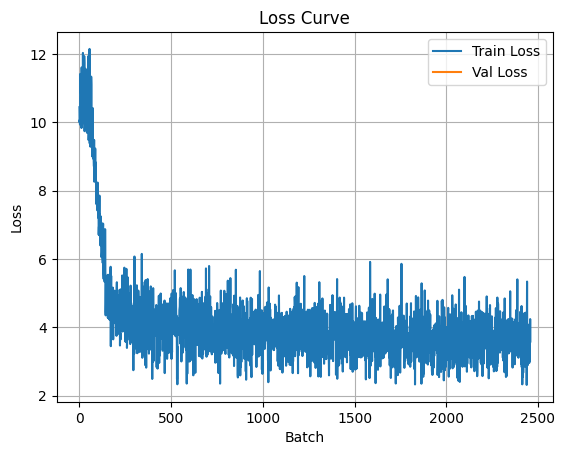

In [14]:
stage2_model = train_step2_pretraining(train_cfg, alm_cfg, stage1_model, tokenizer, device)
stage2_model.save_pretrained("/content/")

In [15]:
final_model = train_step3_instruction_tuning(train_cfg, alm_cfg, stage2_model, tokenizer, device)
final_model.save_pretrained("/content/")

=== Stage 3: Instruction Tuning ===
AudioProcessor_from_HF initialized with model: <class 'transformers.models.whisper.processing_whisper.WhisperProcessor'>
  Target feature frames from cfg: 1500
  Using model sampling rate: 16000, hop_length: 160, n_fft: 400
  Calculated max raw audio samples for processor: 240240
Stage 3: Training all 1,981,650,944 parameters


AttributeError: 'AudioTransformer_from_HF' object has no attribute 'parameters'

As you can see the model trains, so feel free to play around with the architecture or data! Let us know what you build with it!

PS: If you want to test the model, check out generate.py to see how to do inference with it

### Test

In [20]:
!cp /content/drive/MyDrive/nanoALM/output_txt1.wav /content/output_txt1.wav
!cp /content/drive/MyDrive/nanoALM/output_txt2.wav /content/output_txt2.wav
!cp /content/drive/MyDrive/nanoALM/output_txt3.wav /content/output_txt3.wav

In [26]:
!cp ../model.safetensors /content/drive/MyDrive/nanoALM/model.safetensors
!cp ../config.json /content/drive/MyDrive/nanoALM/config.json
!cp ./model.safetensors /content/drive/MyDrive/nanoALM
!cp ./config.json /content/drive/MyDrive/nanoALM

cp: cannot stat './model.safetensors': No such file or directory
cp: cannot stat './config.json': No such file or directory


In [25]:
# final_model.save_pretrained("/content/")
!python generate.py --checkpoint ../ --audio ../output_txt1.wav

2025-07-30 03:06:34.340178: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753844794.361295   31312 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753844794.367746   31312 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Using device: cuda
Loading weights from: ../
load model from local
AudioProcessor_from_HF initialized with model: <class 'transformers.models.whisper.processing_whisper.WhisperProcessor'>
  Target feature frames from cfg: 1500
  Using model sampling rate: 16000, hop_length: 160, n_fft: 400
  Calculated max raw audio samples for processor: 240240

Input:
  What is said in this audio? 

Outputs:
Traceback (most recent call last):
  Fil

In [2]:
!python generate.py --checkpoint ../ --audio ../output_txt2.wav

python3: can't open file '/content/generate.py': [Errno 2] No such file or directory


In [5]:
!python generate.py --checkpoint ../ --audio ../output_txt3.wav

2025-07-30 03:17:31.903458: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-30 03:17:31.921732: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753845451.943344   34381 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753845451.949987   34381 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-30 03:17:31.972157: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [ ]:
!python generate.py --checkpoint ../ --audio ../output_txt3.wav